In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.inequality import gini, lorenz_curve
from qe_inequality_model import *
import statsmodels.api as sm
from matplotlib import style
import scipy.stats as stats
from statsmodels.iolib.summary2 import summary_col
from functions.find_bubbles import *

In [2]:
style.use('ggplot')

In [3]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

# Non-qe model dynamics

In [25]:
NRUNS = 2
burn_in_period = 0

In [30]:
params = {"fundamental_values": [105, 166], "asset_types": ['stock', 'stock'],
              "trader_sample_size": 22, "n_traders": 500,
              "ticks": 500, "std_fundamentals": [0.1, 0.1],
              "std_noise": 0.1007, "w_random": 0.1,
              "strat_share_chartists": 0.0,
              "init_assets": [200, 200], "base_risk_aversion": 1.0,
              'spread_max': 0.004087, "horizon": 200,
              "fundamentalist_horizon_multiplier": 0.2,
              "trades_per_tick": 3, "mutation_intensity": 0.0,
              "average_learning_ability": 0.0, 'money_multiplier': 1.0,
              "bond_mean_reversion": 0.8,
              "qe_perc_size": 0.0, "qe_start": 10, "qe_end": 50, "qe_asset_index": 0}

In [31]:
trdrs = []
orbs = []
central_banks = []

for seed in range(NRUNS): 
    traders, central_bank, orderbook = init_objects_qe_ineq(params, seed)
    traders, central_bank, orderbook = qe_ineq_model(traders, central_bank, orderbook, params, seed)
    central_banks.append(central_bank)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1


# Prices & Volume

In [32]:
asset_prices = []
asset_fundamentals = []
asset_volumes = []

for idx, a in enumerate(params['asset_types']):
    ap = pd.DataFrame([orbs[run][idx].tick_close_price for run in range(NRUNS)]).transpose()
    asset_prices.append(ap)
    
    fn = pd.DataFrame([orbs[run][idx].fundamental for run in range(NRUNS)]).transpose()
    asset_fundamentals.append(fn)
    
    av = pd.DataFrame([[sum(v) for v in orbs[run][0].transaction_volumes_history] for run in range(NRUNS)]).transpose()
    asset_volumes.append(av)

Text(0, 0.5, 'Volume')

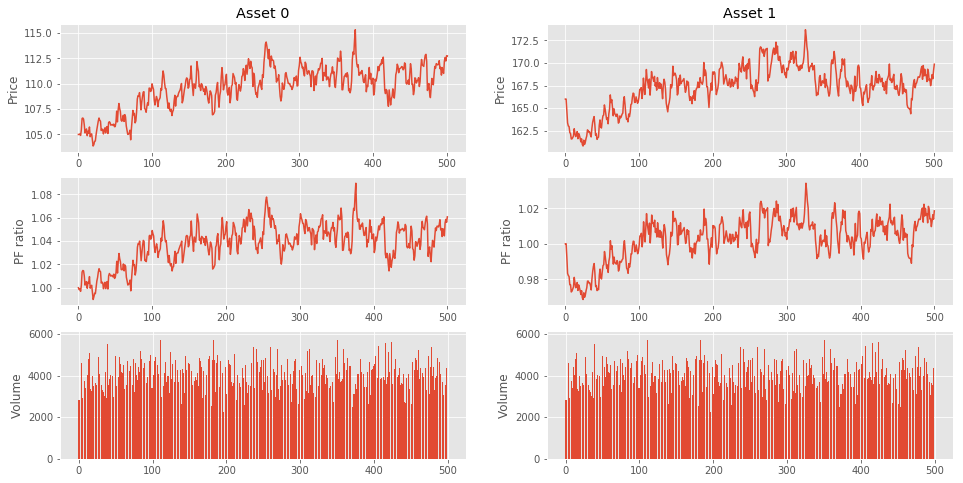

In [33]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,8))

# prices
ax1.set_title('Asset 0')
ax1.plot(asset_prices[0].index, asset_prices[0].mean(axis=1))
ax1.set_ylabel('Price')

ax2.set_title('Asset 1')
ax2.plot(asset_prices[1].index, asset_prices[1].mean(axis=1))
ax2.set_ylabel('Price')

# pd ratio's 
ax3.plot(asset_prices[0].index, asset_prices[0].mean(axis=1) / asset_fundamentals[0].mean(axis=1))
ax3.set_ylabel('PF ratio')

ax4.plot(asset_prices[1].index, asset_prices[1].mean(axis=1) / asset_fundamentals[1].mean(axis=1))
ax4.set_ylabel('PF ratio')

# volumes
ax5.bar(asset_volumes[0].index, asset_volumes[0].mean(axis=1))
ax5.set_ylabel('Volume')

ax6.bar(asset_volumes[1].index, asset_volumes[0].mean(axis=1))
ax6.set_ylabel('Volume')


# Balance sheets

### Central bank

In [95]:
av_price = asset_prices[params["qe_asset_index"]].mean(axis=1)
av_cb_asset_holdings = pd.DataFrame([central_banks[run].var.assets[params["qe_asset_index"]] for run in range(NRUNS)]).transpose().mean(axis=1)
av_cb_currency = pd.DataFrame([central_banks[run].var.currency for run in range(NRUNS)]).transpose().mean(axis=1)

Text(0, 0.5, 'Asset 0')

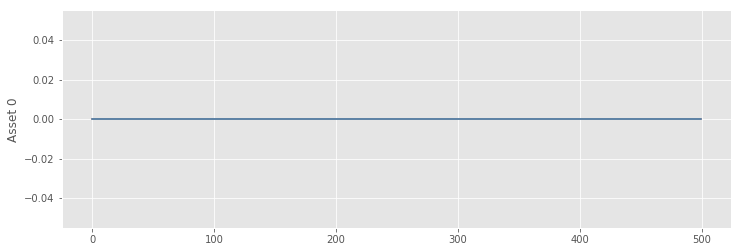

In [96]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,4))

ax1.plot(av_price.index, av_price * av_cb_asset_holdings, label='assets')
ax1.plot(av_cb_currency.index, av_cb_currency, label='currency')

ax1.set_ylabel('Asset 0', fontsize='12')

## Traders

# Expectations

In [97]:
def market_sentiment_in_round(order_book, t):
    return sum(np.array(order_book.sentiment_history[t]) / len(order_book.sentiment_history[t]))

In [98]:
# what do I need, average sentiment + confidence intervals
av_fundamentalist_sentiment = []
lo_fundamentalist_sentiment = []
up_fundamentalist_sentiment = []

av_trend_sentiment = []
lo_trend_sentiment = []
up_trend_sentiment = []

av_random_sentiment = []
lo_random_sentiment = []
up_random_sentiment = []

av_lambda = []
lo_lambda = []
up_lambda = []

for t in range(len(orbs[0][0].sentiment_history)):
    sentiment = []
    for orderb in orbs:
        sentiment.append(market_sentiment_in_round(orderb[0], t))
    f_sents = [s[0] for s in sentiment]
    c_sents = [s[1] for s in sentiment]
    r_sents = [s[2] for s in sentiment]
    lmbda = np.array([c_sents]) / (np.array([c_sents]) + np.array([f_sents]))
    # calculate the average and conf intervals
    av_fundamentalist_sentiment.append(np.mean(f_sents))
    low, up = confidence_interval(f_sents, np.mean(f_sents))
    lo_fundamentalist_sentiment.append(low)
    up_fundamentalist_sentiment.append(up)
    
    av_trend_sentiment.append(np.mean(c_sents))
    low, up = confidence_interval(c_sents, np.mean(c_sents))
    lo_trend_sentiment.append(low)
    up_trend_sentiment.append(up)
    
    av_random_sentiment.append(np.mean(r_sents))
    low, up = confidence_interval(r_sents, np.mean(r_sents))
    lo_random_sentiment.append(low)
    up_random_sentiment.append(up)
    
    av_lambda.append(np.mean(lmbda))
    low, up = confidence_interval(lmbda, np.mean(lmbda))
    lo_lambda.append(low)
    up_lambda.append(up)

Text(0, 0.5, 'Share trend-following')

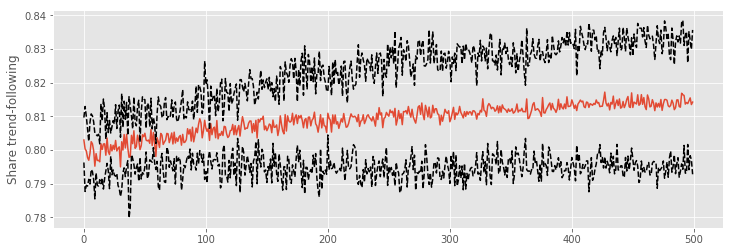

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

ax.plot(range(len(av_lambda[burn_in_period:])), av_lambda[burn_in_period:])
ax.plot(range(len(av_lambda[burn_in_period:])), lo_lambda[burn_in_period:], 'k--')
ax.plot(range(len(av_lambda[burn_in_period:])), up_lambda[burn_in_period:], 'k--')
ax.set_ylabel('Share trend-following', fontsize='12')

# Inequality

In [100]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = []
horizons = []
learning_abilities = []
chartist_expectations = []
fundamentalist_expectations = []
profits = []
real_profits = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    asset0_start = np.array([x.var.assets[0][0] for x in traders])
    asset1_start = np.array([x.var.assets[1][0] for x in traders])
    wealth_start = money_start + (asset0_start * orbs[seed][0].tick_close_price[0]) + (asset1_start * orbs[seed][1].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    asset0_end = np.array([x.var.assets[0][-1] for x in traders])
    asset1_end = np.array([x.var.assets[1][-1] for x in traders])
    wealth_end = money_end + (asset0_end * orbs[seed][0].tick_close_price[-1]) + (asset1_end * orbs[seed][1].tick_close_price[-1])

    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    #market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    # determine characteristics of the agents
    risk_aversions.append([x.par.risk_aversion for x in traders])
    horizons.append([x.par.horizon for x in traders])
    learning_abilities.append([x.par.learning_ability for x in traders])
    chartist_expectations.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        asset0 = np.array([x.var.assets[0][t] for x in traders])
        asset1 = np.array([x.var.assets[1][t] for x in traders])
        wealth = money + (asset0 * orbs[seed][0].tick_close_price[t]) + (asset1 * orbs[seed][1].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    twtws_ot.append(twentytwenty_over_time)

In [101]:
# first, order all profits, then get average profit and conf intervals 
av_ordered_profits = []
lcf_ordered_profits = []
ucf_ordered_profits = []

ordered_profits = [pd.Series(pr).sort_values() for pr in profits]
for a in range(len(ordered_profits[0])):
    a_profits = [list(p)[a] for p in ordered_profits]
    av_ordered_profits.append(np.mean(a_profits))
    low, up = confidence_interval(a_profits, np.mean(a_profits))
    lcf_ordered_profits.append(low)
    ucf_ordered_profits.append(up)

In [102]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

av_twtw_ot = []
low_twtw_ot = []
up_twtw_ot = []

for t in range(burn_in_period, params['ticks']):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(min(up, 1))

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(max(low, 0))
    up_palma_ot.append(up)
    
    t_twtw = [tw[t] for tw in twtws_ot]
    av_twtw_ot.append(np.mean(t_twtw))
    low, up = confidence_interval(t_twtw, np.mean(t_twtw))
    low_twtw_ot.append(max(low, 0))
    up_twtw_ot.append(up)

Text(0.5, 0, 'Agents')

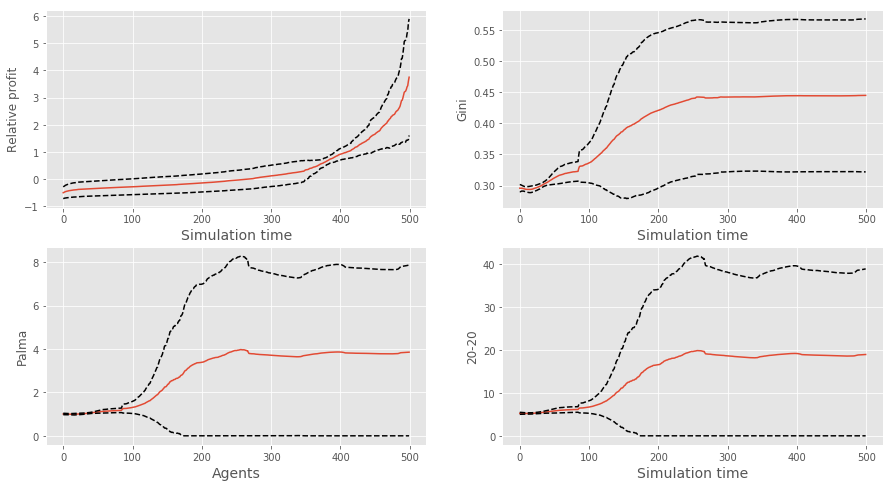

In [103]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(15,8))

ax1.plot(range(len(av_ordered_profits)), av_ordered_profits)
ax1.plot(range(len(av_ordered_profits)), ucf_ordered_profits, 'k--')
ax1.plot(range(len(av_ordered_profits)), lcf_ordered_profits, 'k--')
ax1.set_ylabel('Relative profit', fontsize='12')

ax2.plot(range(len(av_gini_ot[:])), av_gini_ot[:])
ax2.plot(range(len(low_gini_ot[:])), low_gini_ot[:], 'k--')
ax2.plot(range(len(up_gini_ot[:])), up_gini_ot[:], 'k--')
ax2.set_ylabel('Gini', fontsize='12')

ax3.plot(range(len(av_gini_ot[:])), av_palma_ot[:])
ax3.plot(range(len(low_gini_ot[:])), low_palma_ot[:], 'k--')
ax3.plot(range(len(up_gini_ot[:])), up_palma_ot[:], 'k--')
ax3.set_ylabel('Palma', fontsize='12')

ax4.plot(range(len(av_gini_ot[:])), av_twtw_ot[:])
ax4.plot(range(len(low_gini_ot[:])), low_twtw_ot[:], 'k--')
ax4.plot(range(len(up_gini_ot[:])), up_twtw_ot[:], 'k--')
ax4.set_ylabel('20-20', fontsize='12')

for ax in (ax1, ax2, ax4, ax5, ax6):
    ax.set_xlabel('Simulation time', fontsize='14')
    
ax3.set_xlabel('Agents', fontsize='14')

#fig.savefig('short_baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)